## Meter Reading Data 

The meter reading houses data on 8 types of meters and their readings on a daily basis 

In [9]:
# Importing the required libraries 
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [2]:
# Reading in the file and inspecting it 
meter_reading = pd.read_csv("../data/meters/cleaned/allmeters_daily.csv")
meter_reading['date'] = pd.to_datetime(meter_reading['date'])
meter_reading.head()

,building_id,meter,date,meter_reading
0,Bear_assembly_Angel,electricity,2016-01-01,12808.1620
1,Bear_assembly_Angel,electricity,2016-01-02,9251.0003
2,Bear_assembly_Angel,electricity,2016-01-03,14071.6500
3,Bear_assembly_Angel,electricity,2016-01-04,12860.3758
4,Bear_assembly_Angel,electricity,2016-01-05,12212.8585


In [3]:
# Buildings data
metadata = pd.read_csv("../data/metadata/metadata.csv")

# Features from buildings metadata to add to meters dataset for better understanding of the data 
buildings_sel = metadata[["building_id","site_id","primaryspaceusage","timezone"]]
meter_reading = meter_reading.merge(buildings_sel, on="building_id", how = "left")

# Inspect the data 
meter_reading.sample(5)

,building_id,meter,date,meter_reading,site_id,primaryspaceusage,timezone
1042120,Gator_assembly_Gene,electricity,2017-03-21,580.0008,Gator,Entertainment/public assembly,US/Eastern
989330,Fox_office_Berniece,electricity,2016-10-14,609.2500,Fox,Office,US/Mountain
180086,Bull_assembly_Nathanial,steam,2016-09-17,1719.1024,Bull,Entertainment/public assembly,US/Central
1280733,Hog_office_Roger,electricity,2016-01-22,7122.4960,Hog,Office,US/Central
356074,Bull_office_Mai,electricity,2016-03-18,137.0000,Bull,Office,US/Central


## Exploratory Data Analysis (EDA)

### Shape of the Data 

In [4]:
meter_reading.shape

(2231743, 7)

In [5]:
meter_reading.dtypes

building_id                  object
meter                        object
date                 datetime64[ns]
meter_reading               float64
site_id                      object
primaryspaceusage            object
timezone                     object
dtype: object

### Missing Values 

In [6]:
# Percentage of missing values in each feature
na_features = [features for features in meter_reading.columns if meter_reading[features].isnull().sum() > 0]
for features in na_features:
    # Updated to round the missing values percentage to two decimal places
    print(f"{features} : {round(meter_reading[features].isnull().mean() * 100, 2)}%")

primaryspaceusage : 1.8%


### Feature Exploration 

#### Numeric Variables 

##### Univariate Analysis 

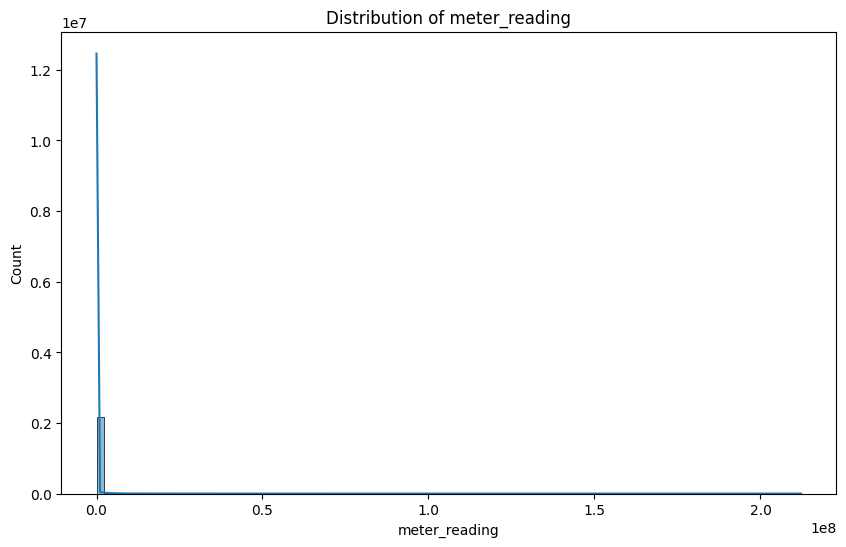

In [10]:
# Distribution of numerical features
for column in ['meter_reading']:
    plt.figure(figsize=(10, 6))
    sns.histplot(meter_reading[column], bins=100, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

The histogram shows the distribution of meter readings, where the majority of the readings are clustered near zero, indicating a highly skewed distribution. There is an extremely low frequency of readings as the meter reading value increases, which suggests that high meter readings are rare or outliers. The y-axis, representing the count, is quite low across the board, which further emphasizes the concentration of smaller values. Since the distribution of the meter readings is very heavily right skewed, we can apply a log transformation to check if the distribution is better.

/tmp/ipykernel_31593/368777212.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(meter_reading["meter_reading"].dropna()+1)) #Adding the 1 to avoid Os


<Axes: xlabel='meter_reading', ylabel='Density'>

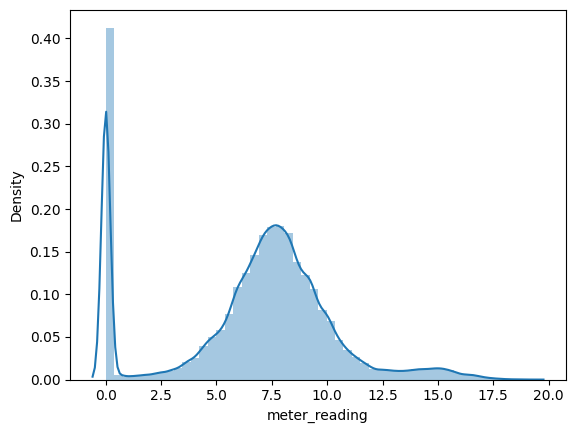

In [11]:
# Log transformation 
sns.distplot(np.log(meter_reading["meter_reading"].dropna()+1)) #Adding the 1 to avoid Os 

We can confirm doing the log transformation on the meter readings will be beneficial and effective fix to the skew

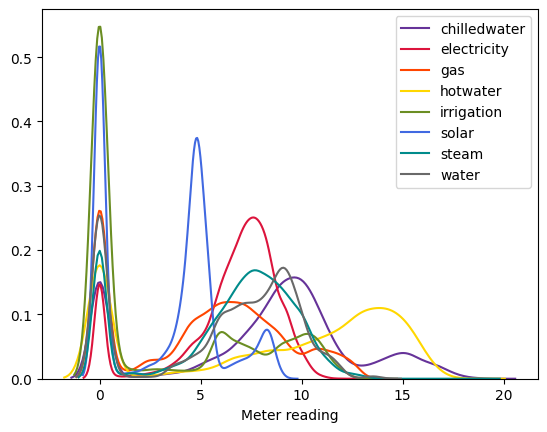

In [12]:
# Distribution by Meter

colors = ["rebeccapurple", "crimson", "orangered", "gold", "olivedrab", "royalblue", "darkcyan", "dimgrey"]

meter_types = ["chilledwater", "electricity", "gas", "hotwater", "irrigation", "solar", "steam", "water"]

f, axes = plt.subplots(1, 1)

for i, meter_type in enumerate(meter_types):
    data = np.log(meter_reading.dropna().loc[meter_reading["meter"] == meter_type, "meter_reading"] + 1)
    sns.kdeplot(data, color=colors[i], label=meter_type, ax=axes, bw_method=0.1)

axes.set(ylabel="", xlabel="Meter reading")
axes.legend()
plt.show()

- The graph shows distinct energy consumption patterns across various meter types, with notable peaks indicating preferred operating ranges.
- Specifically, electricity and gas meters display sharp, pronounced peaks, suggesting these resources are consistently used within narrow consumption bands, likely reflecting standardized usage patterns in buildings.
- Conversely, solar and irrigation meters exhibit broader, flatter distributions, indicating more variable usage, which could be due to factors such as weather variability affecting solar power generation and seasonal changes impacting irrigation needs.
- This diversity in distribution shapes highlights the different operational dynamics and consumption behaviors associated with each energy type.

##### Bivariate Analysis 

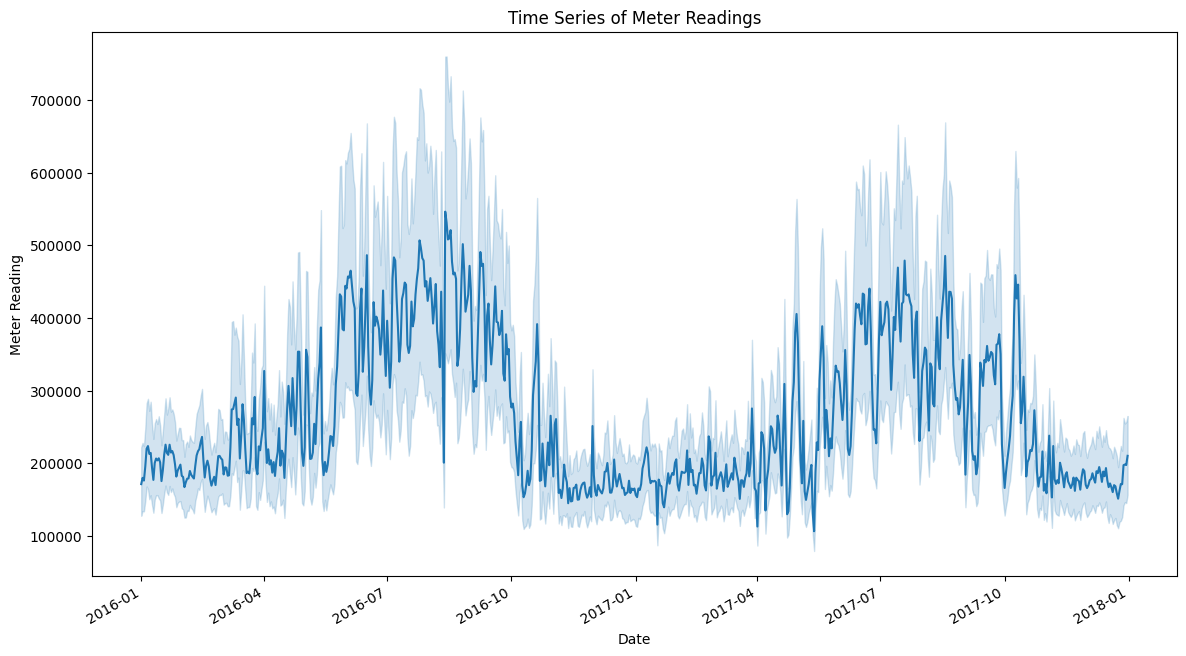

In [13]:
# Time series plot for meter readings over time
plt.figure(figsize=(14, 8))  
sns.lineplot(x='date', y='meter_reading', data=meter_reading)

plt.gcf().autofmt_xdate()  # Auto-format the date labels
plt.title('Time Series of Meter Readings')
plt.xlabel('Date')
plt.ylabel('Meter Reading')

plt.show()

- The time series graph displays the meter readings over a period from January 2016 to February 2017.
- The data exhibits significant fluctuations and a few noticeable peaks, suggesting that there may be periodic trends or that certain times have unusually high readings.
- The confidence interval (shaded area) suggests variability in the readings over time, with some periods having a wider range of readings.
- The overall trend appears to show some seasonality, as indicated by the repeating patterns of peaks and troughs, which could be associated with operational cycles or seasonal usage patterns of the facility or equipment being measured.

Since we have daily data, we can do a temporal analysis for behaviour by month.   
It is important to note that since the meter readings are skewed, we will use median instead of mean

#### Temporal Analysis by Month

In [14]:
# datetime indexes
times = pd.DatetimeIndex(meter_reading.date)

Text(0.5, 0.98, 'Meter reading by month')

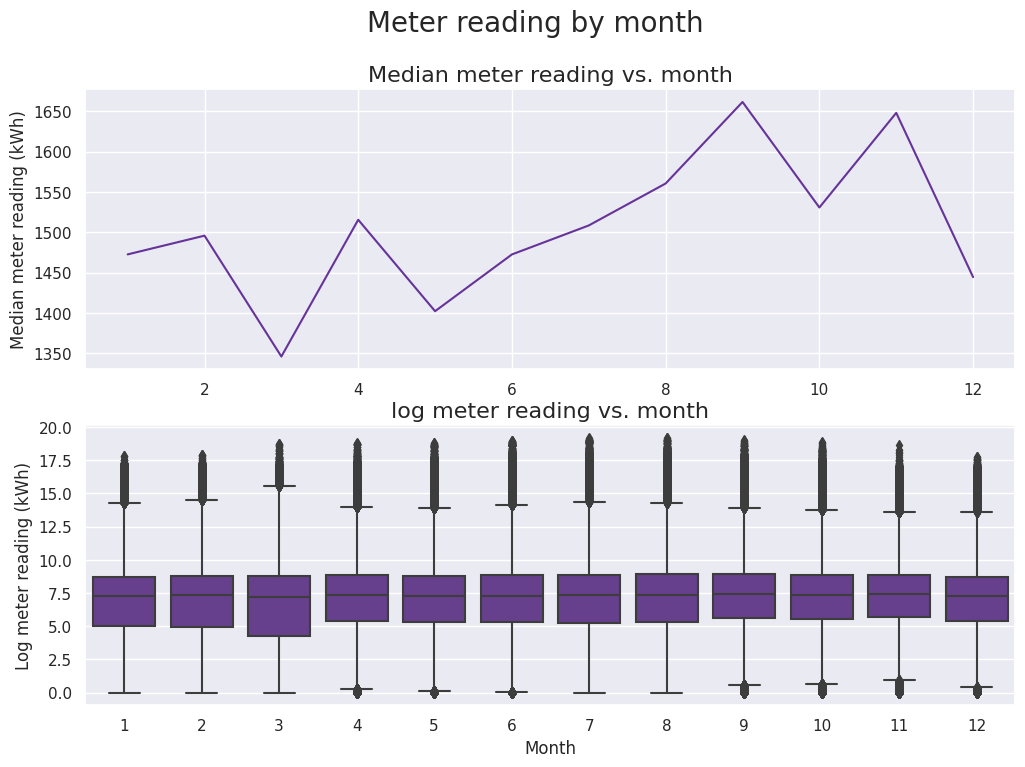

In [15]:
# Median for each month (12)
sns.set(rc={'figure.figsize':(12,8)})
f, axes = plt.subplots(2, 1, sharex=False)
axes = axes.flatten()

temp = meter_reading.groupby(meter_reading['date'].dt.month)['meter_reading'].median().reset_index()

# Plot the data
ax1 = axes[0]
sns.lineplot(data=temp, x="date", y="meter_reading", ax=ax1, color=colors[0])
ax1.set_ylabel("Median meter reading (kWh)")
ax1.set_xlabel("")
ax1.set_title('Median meter reading vs. month', fontdict={'size':16})

temp = pd.DataFrame({
    "month": meter_reading['date'].dt.month, 
    "meter_reading": np.log(meter_reading['meter_reading'] + 1)
})
# boxplot
ax2 = axes[1]
sns.boxplot(data=temp, x="month", y="meter_reading", ax=ax2, color=colors[0])
ax2.set_ylabel("Log meter reading (kWh)")
ax2.set_xlabel("Month")
ax2.set_title('log meter reading vs. month', fontdict={'size':16})

f.suptitle('Meter reading by month', fontsize=20)

- The data indicates seasonal trends in energy usage, with peaks in consumption during certain months, likely corresponding to weather changes affecting heating or cooling needs.
- The variability in log meter readings suggests different usage intensities among buildings or times, with some months showing greater spread and outliers, indicating sporadic high usage or data anomalies.
- Overall, energy consumption is not constant and exhibits significant monthly variation, reflecting differing operational or environmental factors.

Although since we have data for 8 different types of meters it is important to check if there are any monhtly trends by meter type. 

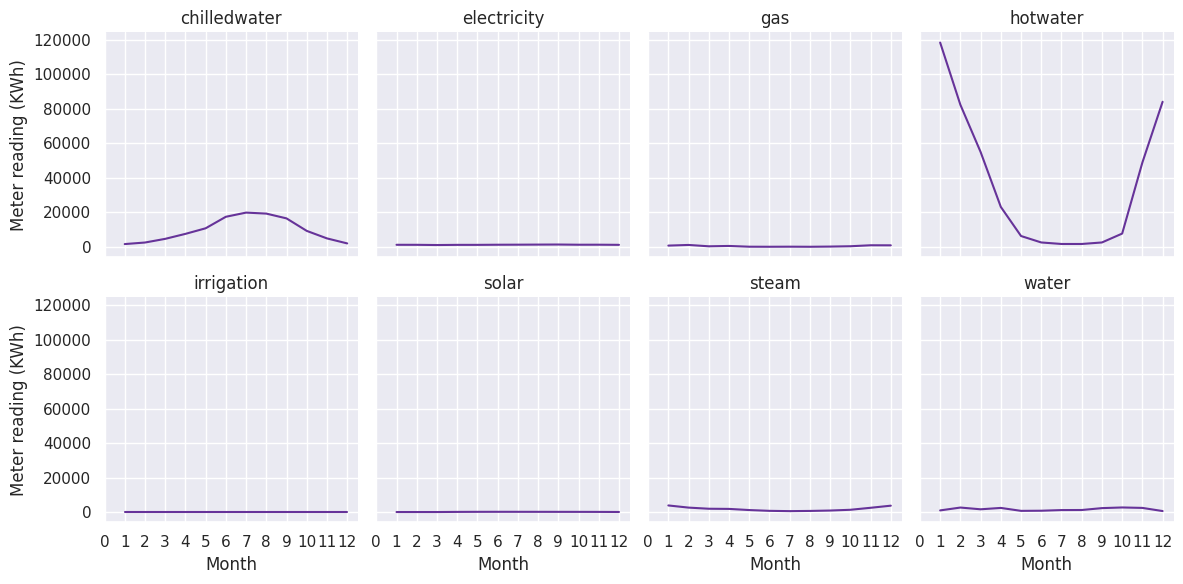

In [16]:
temp = pd.DataFrame(meter_reading.groupby(["meter", meter_reading['date'].dt.month])['meter_reading'].median()).reset_index()
# All the plots in a grid
g = sns.FacetGrid(temp, col="meter", col_wrap=4)
g.map(plt.plot, "date", "meter_reading", color=colors[0])
# Title of each plot
g.set_titles("{col_name}")
# Axis labels
g.set_axis_labels(x_var="Month", y_var="Meter reading (KWh)")
g.set(xticks=range(13))

- Chilled water and hot water show significant seasonal variation, peaking in different months, suggesting they are influenced by external factors like temperature.
 - Electricity, gas, irrigation, solar, steam, and water meters display less pronounced seasonal trends.
 - Notably, hot water usage increases dramatically towards the year-end, possibly due to colder weather. The lack of visible data for some energy types in certain months could indicate missing data or minimal usage.

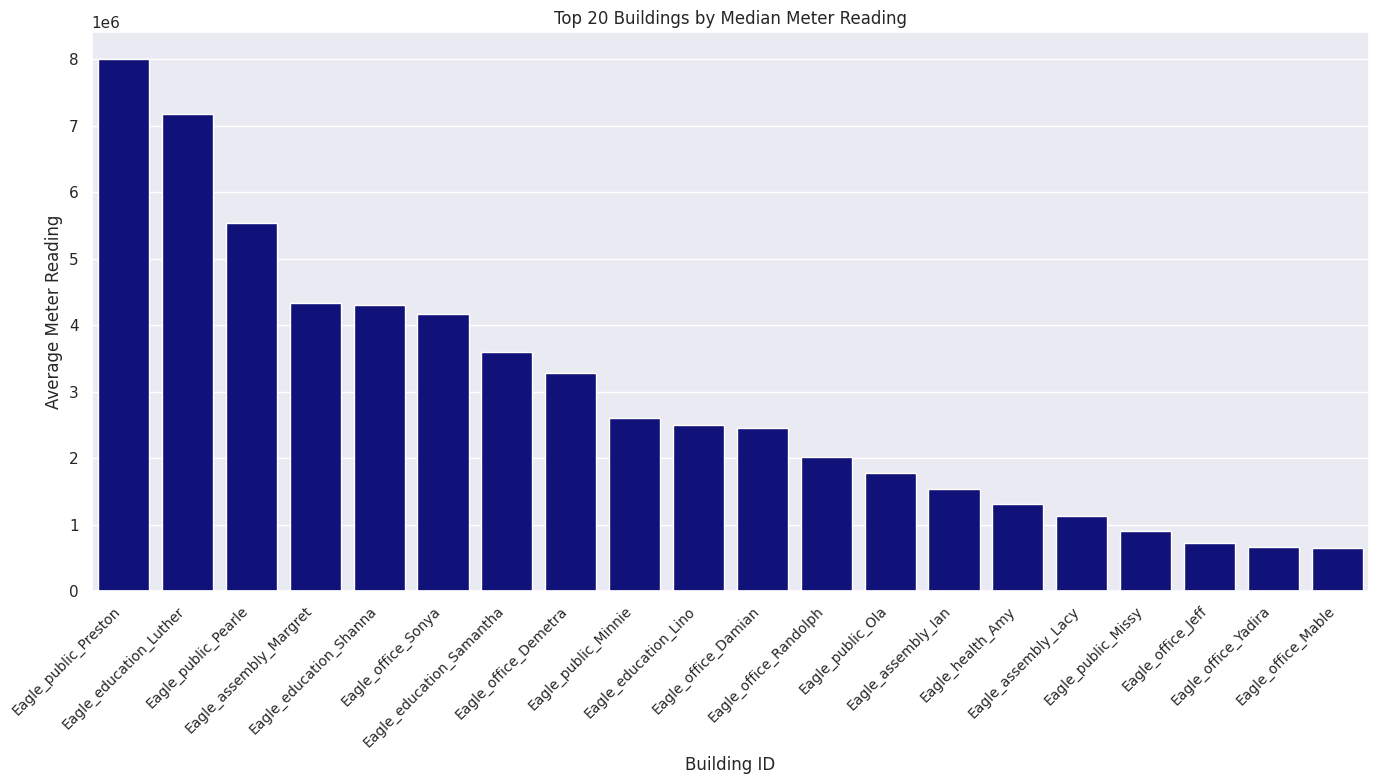

In [17]:
# Average Meter Reading vs. Building ID
# Calculate average meter readings for each building
average_readings_by_building = meter_reading.groupby('building_id')['meter_reading'].median().reset_index()

# Sort the buildings by average meter reading in descending order and select the top 20
top_buildings = average_readings_by_building.sort_values(by='meter_reading', ascending=False).head(20)

# Plotting the average meter readings for the top 20 buildings
plt.figure(figsize=(14, 8))  
barplot = sns.barplot(data=top_buildings, x='building_id', y='meter_reading',color = 'darkblue')
plt.title('Top 20 Buildings by Median Meter Reading')
plt.xlabel('Building ID')
plt.ylabel('Average Meter Reading')

# Rotate the x-axis labels for better readability
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha="right", fontsize=10)  # Adjust fontsize as needed
plt.tight_layout()
plt.show()

- The first building, 'Eagle_education_Peter', has significantly higher average meter readings compared to the others, suggesting it may have higher energy consumption or operational demands.
- The buildings with the highest energy consumption predominantly belong to the 'Eagle_education' category, suggesting these types of buildings might typically have higher energy requirements, or it could reflect a specific subset of your dataset where these buildings are overrepresented.

Finally, since we are working with daily data we can check if there is any variation in meter readings by day of wek

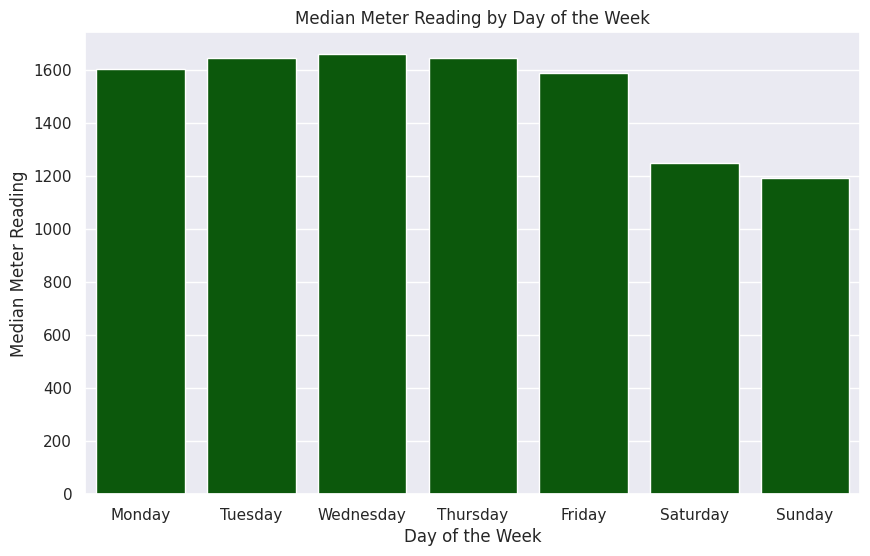

In [18]:
# Extract day of week, month, and hour (if time is available)
meter_reading['day_of_week'] = meter_reading['date'].dt.day_name()
meter_reading['month'] = meter_reading['date'].dt.month

# Aggregate average meter readings by day of the week
avg_by_day = meter_reading.groupby('day_of_week')['meter_reading'].median().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot average meter readings by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_by_day.index, y=avg_by_day.values,color = 'darkgreen')
plt.title('Median Meter Reading by Day of the Week')
plt.ylabel('Median Meter Reading')
plt.xlabel('Day of the Week')
plt.show()

There does not seem to be much variation of meter readings during the week. The weekend seems to have a lower median. 

### Combining with Weather

In [19]:
# Reading in the weather file 
weather = pd.read_csv( "../data/weather/weather.csv")
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

In [20]:
# Combining the datasets and inspecting 
meter_reading = pd.merge(meter_reading, weather, how='left', left_on=['date', 'site_id'], right_on=['timestamp', 'site_id'])
meter_reading.sample(5)

,building_id,meter,date,meter_reading,site_id,primaryspaceusage,timezone,day_of_week,month,timestamp,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
1458746,Lamb_education_Patsy,gas,2017-02-05,434.2810,Lamb,Education,Europe/London,Sunday,2,2017-02-05,4.0,NaN,3.0,NaN,NaN,NaN,130.0,1.5
2131457,Robin_public_Cami,electricity,2017-08-15,1653.7500,Robin,Public services,Europe/London,Tuesday,8,2017-08-15,16.7,NaN,13.1,NaN,-1.0,1014.1,230.0,2.1
1616362,Panther_education_Quintin,electricity,2016-05-01,0.0000,Panther,Education,US/Eastern,Sunday,5,2016-05-01,21.7,NaN,18.9,0.0,NaN,1016.9,120.0,2.1
1174461,Hog_lodging_Hal,steam,2017-04-20,22546.1717,Hog,Lodging/residential,US/Central,Thursday,4,2017-04-20,7.8,8.0,6.1,13.0,60.0,1012.9,340.0,3.6
250600,Bull_education_Linnie,steam,2017-08-21,546.9868,Bull,Education,US/Central,Monday,8,2017-08-21,28.9,0.0,21.1,0.0,NaN,1016.6,NaN,2.6


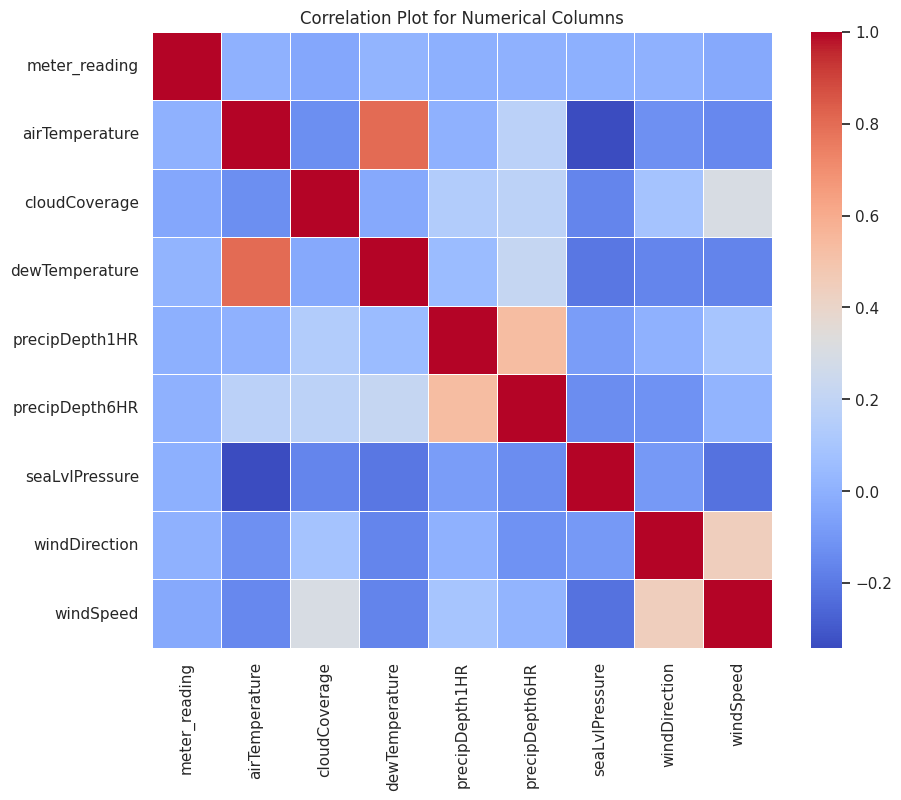

In [21]:
numerical_columns = meter_reading.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numerical_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot for Numerical Columns')
plt.show()

- The pairs (airTemperature_x, airTemperature_y), (dewTemperature_x, dewTemperature_y), and (windSpeed_x, windSpeed_y) show very high positive correlations (0.81 or higher), suggesting that these measurements are very similar between the two sets represented by "_x" and "_y" suffixes, which could represent similar conditions or measurements taken at different times or situations.

- The meter_reading variable has very low correlation with most other variables, often close to 0, indicating it does not share a strong linear relationship with these weather or environmental measurements.

- Some variables like seaLvPressure_x and seaLvPressure_y also have a perfect correlation of 1.00, suggesting they are identical or measure the same phenomenon in different instances or settings.

- Negative correlations are visible but not very strong in this dataset; for example, seaLvPressure_x and airTemperature_x have a correlation of -0.34, indicating a moderate inverse relationship between sea level pressure and air temperature in the "_x" setting.

## Delete Variables

In [ ]:
import gc
del meter_reading, weather, temp
gc.collect()

20557

: 